# Investment optimization: Electric system

Now, the optimal capacities of the energy system that was only dispatch optimized earlier will be determined.

Loading all necessary packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from oemof.solph import (Sink, Source, Transformer, Bus, Flow, Model,
                         EnergySystem, Investment)

import oemof.outputlib as outputlib
import oemof.solph as solph
from oemof.tools import economics

%matplotlib inline

Reading all data and initializing the EnergySystem object:

In [2]:
datetimeindex = pd.date_range('1/1/2016', periods=24*7, freq='H')
filename = 'timeseries/input_data.csv'
data = pd.read_csv(filename, sep=',')
energysystem = EnergySystem(timeindex=datetimeindex)

Define all components that are not to be capacity, ie. investment optimized as before.

In [3]:
# buses
bcoal = Bus(label='coal')
bgas = Bus(label='gas')
bel = Bus(label='electricity')
energysystem.add(bcoal, bgas, bel)

# sources
energysystem.add(Source(label='coal_source', outputs={bcoal: Flow(variable_costs=25*0.39)}))

energysystem.add(Source(label='gas_source', outputs={bgas: Flow(variable_costs=40*0.5)}))

# sources
energysystem.add(Source(label='wind', outputs={bel: Flow(actual_value=data['wind'], 
                                                         nominal_value=66.3, 
                                                         fixed=True)}))

energysystem.add(Source(label='pv', outputs={bel: Flow(actual_value=data['pv'], 
                                                       nominal_value=65.3, 
                                                       fixed=True)}))

# excess and shortage to avoid infeasibilies
energysystem.add(Sink(label='excess_el', inputs={bel: Flow()}))
energysystem.add(Source(label='shortage_el',
                        outputs={bel: Flow(variable_costs=100000000)}))

# demands (electricity/heat)
energysystem.add(Sink(label='demand_el', 
                      inputs={bel: Flow(nominal_value=85, 
                                        actual_value=data['demand_el'], 
                                        fixed=True)}))

Calculate annuity of investments into coal and gas power plant:

In [4]:
epc_coal = economics.annuity(capex=1500000, n=50, wacc=0.05)
epc_gas = economics.annuity(capex=900000, n=20, wacc=0.05)

Introduce investment-objects to components that are to be optimized:

In [5]:
# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(investment=Investment(ep_costs=epc_coal,maximum=5e9, existing=0))},
    conversion_factors={bel: 0.39}))

energysystem.add(Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(investment=Investment(ep_costs=epc_gas,maximum=5e9, existing=0))},
    conversion_factors={bel: 0.50}))

Optimize energy system:

In [6]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver='cbc',
                         solve_kwargs={'tee': False, 'keepfiles': False})

{'Problem': [{'Name': 'unknown', 'Lower bound': 5423472.095, 'Upper bound': 5423472.095, 'Number of objectives': 1, 'Number of constraints': 1177, 'Number of variables': 1347, 'Number of nonzeros': 506, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.04, 'Wallclock time': 0.04, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 337}}, 'Error rc': 0, 'Time': 0.05342268943786621}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Plot results:

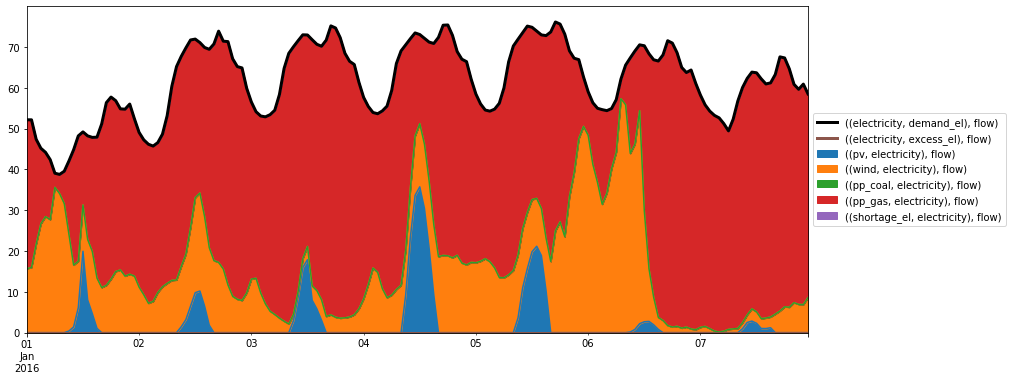

In [7]:
results = outputlib.processing.results(optimization_model)

results_el = outputlib.views.node(results, 'electricity')

el_sequences = results_el['sequences']

to_el = {key[0][0]: key for key in el_sequences.keys() if key[0][1] == 'electricity' and key[1] == 'flow'}
to_el = [to_el.pop('pv'), to_el.pop('wind')] + list(to_el.values())
el_prod = el_sequences[to_el]

fig, ax = plt.subplots(figsize=(14, 6))
el_prod.plot.area(ax=ax)
el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
el_sequences[(('electricity', 'excess_el'), 'flow')].plot(ax=ax, linewidth=3)
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

In [8]:
cap_coal = results_el['scalars'][(('pp_coal', 'electricity'), 'invest')]
cap_gas = results_el['scalars'][(('pp_gas', 'electricity'), 'invest')]
print('Capacity coal: ' + str(cap_coal) + ' \nCapacity gas: ' + str(cap_gas))

Capacity coal: 0.0 
Capacity gas: 70.915068


In [9]:
el_sequences.sum(axis=0)

((electricity, demand_el), flow)      10393.249057
((electricity, excess_el), flow)          0.000000
((pp_coal, electricity), flow)            0.000000
((pp_gas, electricity), flow)          7552.610744
((pv, electricity), flow)               429.239096
((shortage_el, electricity), flow)        0.000000
((wind, electricity), flow)            2411.399209
dtype: float64